## Notebook to prepare/see results of Cross-validation for open- and closed-cell St

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import copy
import glob
import random
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
from pyhdf.SD import SD, SDC 
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3

In [2]:
import gc
import math

In [3]:
from sklearn.cluster import AgglomerativeClustering as AGL
from sklearn.metrics import adjusted_mutual_info_score as AMI

In [4]:
#version1
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.neural_network import MLPClassifier 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#version 2
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit

In [5]:
datadir = "/home/tkurihana/scratch-midway2/data/clouds"

In [6]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))

#### Download patches

- Closed cell

In [7]:
cdatadir = "/project2/foster/clouds/src_analysis/labeled_clouds/close_cells_mod02/"

In [8]:
cpatches_list = []
cfilelist= glob.glob(os.path.join(cdatadir, "*.npy"))
for filename in cfilelist:
    tmp = np.load(filename)
    for patch in tmp:
        #print( len(np.where(np.isnan(patch))[0]) )
        if len(np.where(np.isnan(patch))[0]) == 0:
            cpatches_list.append(patch)
cpatches = np.squeeze(np.concatenate(cpatches_list, axis=0), axis=(1) )

In [9]:
cpatches.shape

(120, 128, 128, 6)

In [10]:
del cpatches_list

- Open cell

In [11]:
odatadir = "/project2/foster/clouds/src_analysis/labeled_clouds/open_cells_mod02"

In [12]:
""" one file is only [8] dimension
"""
opatches_list = []
ofilelist = glob.glob(os.path.join(odatadir, "*.npy"))
for filename in ofilelist:
    a = np.load(filename, allow_pickle=True)
    if a.size > 100:
        for patch in a:
            if len(np.where(np.isnan(patch))[0]) == 0:
                opatches_list.append(patch)
opatches = np.squeeze(np.concatenate(opatches_list, axis=0), axis=(1) )

In [13]:
opatches.shape

(117, 128, 128, 6)

In [14]:
del opatches_list

In [15]:
gc.collect()

105

In [16]:
### Patches
patches = np.concatenate([cpatches, opatches], axis=0)

In [17]:
patches.shape

(237, 128, 128, 6)

##### Make label: 0; closed, 1; open cell

In [18]:
ctest = np.zeros((cpatches.shape[0]))
otest = np.ones((opatches.shape[0]))
label = np.concatenate([ctest, otest])

In [19]:
label.shape

(237,)

#### Practice: 1-time Valiadtion

In [94]:
X_train, X_test, y_train, y_test = train_test_split(patches, label, test_size=0.4, random_state=0)

In [101]:
X_train.shape, y_train.shape

((142, 128, 128, 6), (142,))

In [106]:
n,h,w,c = X_train.shape

In [107]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train.reshape(n, h*w*c), y_train)

In [109]:
n,h,w,c = X_test.shape
clf.score(X_test.reshape(n, h*w*c), y_test)

0.9157894736842105

#### Practice: Cross-validation

In [112]:
clf = svm.SVC(kernel='linear', C=1)
n,h,w,c = patches.shape
scores = cross_val_score(clf, patches.reshape(n, h*w*c), label, cv=5)

In [113]:
scores

array([0.83333333, 0.9375    , 0.82978723, 0.85106383, 0.85106383])

with metric

In [115]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')

In [116]:
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

#### Practice: Cross-validate function

In [118]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, patches.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [2.18492413 2.4025774  1.95280457 1.84609723 2.21522784]
score_time [0.89239097 1.02013183 0.76489997 0.78053904 0.86005235]
test_precision_macro [0.83333333 0.93826087 0.83181818 0.85740741 0.88709677]
test_recall_macro [0.83333333 0.9375     0.83061594 0.84963768 0.84782609]


#### Practice: Repeate Cross validation

In [125]:
ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for train_index, test_index in ss.split(np.arange(0, patches.shape[0],1)):
    #print("%s %s" % (train_index, test_index))
    X_train = patches[train_index]
    Y_test  = patches[test_index]
    x_label = label[train_index]
    y_label = label[test_index]

### Use autoencoder and check performance

In [28]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

#### RI autoencoder 

In [29]:
# 67011582; Best model
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = 67011582
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')

 Load encoder at 100 epoch


In [148]:
# change patch size
height = width = 32
rpatches_tf = tf.image.resize_images(patches, (height, width))
rpatches_tf = tf.cast(rpatches_tf, tf.float64)
rpatches = tf.keras.backend.eval(rpatches_tf)

# standardization
nmin = np.amin(rpatches, axis=(0,1,2))
nmax = np.amax(rpatches, axis=(0,1,2))
rpatches = (rpatches - nmin)/(nmax - nmin)
rpatches.shape

(237, 32, 32, 6)

Linear

In [149]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.02354741 0.02398419 0.02123642 0.01896548 0.02294421]
score_time [0.01252246 0.01094294 0.00980878 0.00849438 0.01057386]
test_precision_macro [0.81304348 0.94444444 0.83181818 0.78909091 0.92857143]
test_recall_macro [0.8125     0.9375     0.83061594 0.78804348 0.91304348]


RBF

In [150]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(gamma=2, random_state=0)
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

fit_time [0.0869801  0.09412098 0.09649682 0.0819664  0.08466935]
score_time [0.07198858 0.05639362 0.06329393 0.04183602 0.05602431]
test_precision_macro [0.25       0.24468085 0.25531915 0.25531915 0.25531915]
test_recall_macro [0.5        0.47916667 0.5        0.5        0.5       ]


MLP

In [158]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=2, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [247.19460917 304.24902368]
score_time [0.17841578 0.12321925]
test_precision_macro [0.91360505 0.89105339]
test_recall_macro [0.90706215 0.88936782]


In [165]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fit_time [276.62142754 353.07320738 346.02472138 275.18099546 289.90711761]
score_time [0.02053118 0.09346724 0.00628734 0.00721383 0.0796268 ]
test_precision_macro [0.87023593 0.96153846 0.85144928 0.79537037 0.91849817]
test_recall_macro [0.85416667 0.95833333 0.85144928 0.78894928 0.91394928]


RandomForest

In [161]:
scoring = ['precision_macro', 'recall_macro']
clf =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.01461339 0.01359177 0.01640391 0.00810218 0.00860667]
score_time [0.00445437 0.00429702 0.0045228  0.0026834  0.00292873]
test_precision_macro [0.89652174 0.93826087 0.77819549 0.89454545 0.92857143]
test_recall_macro [0.89583333 0.9375     0.76811594 0.89311594 0.91304348]


AdaBoost

In [163]:
scoring = ['precision_macro', 'recall_macro']
clf =  AdaBoostClassifier()
encs = encoder.predict(rpatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [1.92635083 2.44037914 2.39723921 2.35921383 2.44672012]
score_time [0.02276087 0.02757215 0.02309465 0.02349663 0.02296019]
test_precision_macro [0.91666667 0.94444444 0.90092593 0.89454545 0.9137931 ]
test_recall_macro [0.91666667 0.9375     0.89221014 0.89311594 0.89130435]


#### NRI autoencoder

In [30]:
# 'm2_02_global_2000_2018_band28_29_31'
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = 'm2_02_global_2000_2018_band28_29_31'
model_dir = os.path.join(model_datadir,str(expname) )
nriencoder = load_latest_model(model_dir, mtype='encoder')

 Load encoder at 100000 epoch


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [137]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
encs = nriencoder.predict(patches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.12828207 0.15790749 0.12065506 0.1190412  0.13650012]
score_time [0.05376101 0.07097888 0.05228615 0.05123711 0.0618856 ]
test_precision_macro [0.9021164  0.96153846 0.87545788 0.83971774 0.9137931 ]
test_recall_macro [0.89583333 0.95833333 0.87137681 0.80525362 0.89130435]


In [159]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = nriencoder.predict(patches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=2, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fit_time [ 10.70810747 766.75788379]
score_time [0.41641521 0.47076082]
test_precision_macro [0.92253521 0.91666667]
test_recall_macro [0.90677966 0.89655172]


In [166]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = nriencoder.predict(patches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fit_time [813.8486774  596.98655963  22.70966363 927.69674039  20.7441051 ]
score_time [0.01212454 0.01099968 0.022084   0.01797223 0.01471686]
test_precision_macro [0.92857143 0.98       0.92857143 0.85392157 0.89454545]
test_recall_macro [0.91666667 0.97916667 0.91304348 0.82699275 0.89311594]


In [162]:
scoring = ['precision_macro', 'recall_macro']
clf =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
encs = nriencoder.predict(patches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.02940154 0.02922893 0.02957559 0.02761221 0.02761197]
score_time [0.0088613  0.00885057 0.00910378 0.00872827 0.0088532 ]
test_precision_macro [0.85555556 0.91958042 0.87545788 0.746337   0.8843985 ]
test_recall_macro [0.83333333 0.91666667 0.87137681 0.74365942 0.87047101]


In [164]:
scoring = ['precision_macro', 'recall_macro']
clf =  AdaBoostClassifier()
encs = nriencoder.predict(patches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=5, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [9.44690204 8.9894042  9.40780926 9.28659058 9.74264002]
score_time [0.02756834 0.03544092 0.0301137  0.03513455 0.03478169]
test_precision_macro [0.9        0.96153846 0.80887681 0.77037037 0.86877395]
test_recall_macro [0.875      0.95833333 0.80887681 0.76449275 0.84873188]


---------------------
### Rotate and compare

In [20]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    return rtest_imgs

In [21]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

#### Renew Labels

In [24]:
ctest = np.zeros((6*cpatches.shape[0]))
otest = np.ones((6*opatches.shape[0]))
labels = np.concatenate([ctest, otest])
print(labels.shape)

(1422,)


##### RI

In [25]:
# change patch size
height = width = 32
rpatches_tf = tf.image.resize_images(patches, (height, width))
rpatches_tf = tf.cast(rpatches_tf, tf.float64)
rpatches = tf.keras.backend.eval(rpatches_tf)

# standardization
nmin = np.amin(rpatches, axis=(0,1,2))
nmax = np.amax(rpatches, axis=(0,1,2))
rpatches = (rpatches - nmin)/(nmax - nmin)
rpatches.shape

(237, 32, 32, 6)

In [26]:
sri_patches = copy_rot_fn(rpatches, height=32, width=32, ch=6, copy_size=6)

(1422, 32, 32, 6)
1422


In [31]:
encs = encoder.predict(sri_patches)
n,h,w,c = encs.shape
ri_colabels = AGL(n_clusters=2).fit_predict(encs.reshape(n, h*w*c))

In [32]:
AMI(labels, ri_colabels)

0.5204898377737586

In [33]:
scoring = ['accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision','roc_auc', ]
clf = svm.SVC(kernel='linear', C=1, random_state=0)
#encs = encoder.predict(sri_patches)
#n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), labels, cv=3, scoring=scoring)
scores

{'fit_time': array([0.37762594, 0.37261128, 0.35603809]),
 'score_time': array([0.31810379, 0.31478858, 0.29779029]),
 'test_accuracy': array([0.87130802, 0.92616034, 0.90084388]),
 'test_precision': array([0.85306122, 0.93449782, 0.91928251]),
 'test_recall': array([0.89316239, 0.91452991, 0.87606838]),
 'test_f1': array([0.87265136, 0.92440605, 0.89715536]),
 'test_average_precision': array([0.97494099, 0.98249717, 0.97280874]),
 'test_roc_auc': array([0.97284544, 0.9795406 , 0.97512464])}

In [53]:
np.mean([0.85306122, 0.93449782, 0.91928251]), np.std([0.85306122, 0.93449782, 0.91928251])

(0.9022805166666666, 0.03535327224713471)

In [58]:
np.mean([0.97494099, 0.98249717, 0.97280874]), np.std([0.97494099, 0.98249717, 0.97280874])

(0.9767489666666668, 0.004156761855630228)

In [54]:
np.mean([0.89316239, 0.91452991, 0.87606838]), np.std([0.89316239, 0.91452991, 0.87606838])

(0.8945868933333333, 0.015734129142201944)

In [55]:
np.mean([0.87130802, 0.92616034, 0.90084388]), np.std([0.87130802, 0.92616034, 0.90084388])

(0.8994374133333333, 0.022415439079779144)

In [36]:
gc.collect()

0

##### NRI

In [35]:
patches.shape[0]

237

In [ ]:
del sri_patches

In [37]:
gc.collect()
snri_patches = copy_rot_fn(patches, height=128, width=128, ch=6, copy_size=6)

(1422, 128, 128, 6)
1422


In [38]:
gc.collect()

0

In [40]:
nriencs = nriencoder.predict(sri_patches)
n,h,w,c = nriencs.shape
nri_colabels = AGL(n_clusters=2).fit_predict(nriencs.reshape(n, h*w*c))

In [42]:
AMI(labels, nri_colabels)

0.0764029328759832

In [43]:
scoring = ['accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision','roc_auc', ]
clf = svm.SVC(kernel='linear', C=1, random_state=0)
#encs = encoder.predict(sri_patches)
#n,h,w,c = encs.shape
scores = cross_validate(clf, nriencs.reshape(n, h*w*c), labels, cv=3, scoring=scoring)
scores

{'fit_time': array([2.5493741 , 2.38955235, 2.2855444 ]),
 'score_time': array([2.15917516, 2.03909278, 1.90741038]),
 'test_accuracy': array([0.89873418, 0.87552743, 0.87974684]),
 'test_precision': array([0.83453237, 0.95811518, 0.98895028]),
 'test_recall': array([0.99145299, 0.78205128, 0.76495726]),
 'test_f1': array([0.90625   , 0.86117647, 0.8626506 ]),
 'test_average_precision': array([0.98687061, 0.96697492, 0.96836901]),
 'test_roc_auc': array([0.98659188, 0.96175214, 0.96061254])}

In [47]:
for i in scores.keys():
    print(i, scores[i])

fit_time [2.5493741  2.38955235 2.2855444 ]
score_time [2.15917516 2.03909278 1.90741038]
test_accuracy [0.89873418 0.87552743 0.87974684]
test_precision [0.83453237 0.95811518 0.98895028]
test_recall [0.99145299 0.78205128 0.76495726]
test_f1 [0.90625    0.86117647 0.8626506 ]
test_average_precision [0.98687061 0.96697492 0.96836901]
test_roc_auc [0.98659188 0.96175214 0.96061254]


In [57]:
np.mean([0.83453237, 0.95811518,0.98895028]), np.std([0.83453237, 0.95811518, 0.98895028])

(0.9271992766666667, 0.0667236466898057)

In [59]:
np.mean([0.99145299,0.78205128,0.76495726]), np.std([0.99145299,0.78205128,0.76495726])

(0.8461538433333334, 0.1029787450447461)

In [60]:
np.mean([0.89873418,0.87552743,0.87974684]), np.std([0.89873418,0.87552743,0.87974684])

(0.8846694833333334, 0.010093318728447181)

save concat-patch data as npy file

In [44]:
np.save('closed-opencells.npy', patches)

In [51]:
237*6

1422

In [52]:
1422//200

7

K-5

In [64]:
def clac(x):
    print(np.mean(x), np.std(x))

In [62]:
# ri-acc
np.mean([0.83157895,0.93684211,0.8943662,0.88732394,0.95070423]), np.std([0.83157895,0.93684211,0.8943662,0.88732394,0.95070423])

(0.9001630860000001, 0.04195709548239514)

In [63]:
# ri -pre
x = [0.82068966,0.88679245,0.93650794,0.84615385,0.9921875 ]
np.mean(x), np.std(x)

(0.89646628, 0.061859366682568306)

In [65]:
# ri recall
clac(x=[0.84397163,1.,0.84285714,0.94285714,0.90714286])

0.907365754 0.06003493638183208


In [66]:
#nri precisopn
clac(x=[0.79545455,0.89240506,0.98130841,0.95454545,1.])
#nri recall
clac(x=[0.9929078,1.,0.75,0.75,0.81428571])
#nri acc
clac(x=[0.87017544,0.94035088,0.86971831,0.85915493,0.9084507])

0.9247426940000001 0.07417909860580475
0.8614387020000001 0.11273325178829899
0.8895700520000001 0.030431870276423963


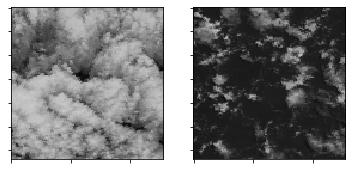

In [79]:
plt.figure()
vmi = np.nanmin(patches[:,:,:,0])
vma = np.nanmax(patches[:,:,:,0])
for ii,j  in enumerate([30,181]):
    ax = plt.subplot(1,2,ii+1)
    ax.imshow(patches[j, :,:,0], cmap='gist_gray', vmin=vmi, vmax=vma)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()
plt.close()

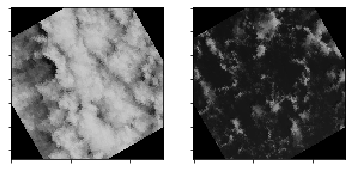

In [87]:
plt.figure()
vmi = np.nanmin(sri_patches[:,:,:,0])
vma = np.nanmax(sri_patches[:,:,:,0])
for ii,j  in enumerate([30*6-4,181*6-1]):
    ax = plt.subplot(1,2,ii+1)
    ax.imshow(sri_patches[j, :,:,0], cmap='gist_gray', vmin=vmi, vmax=vma)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()
plt.close()